In [1]:
# Required Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
# Download NLTK Resources
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set up Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
# Expanded list of stopwords including bigrams
SINGLE_STOPWORDS = set(stopwords.words('english')).union({
    # General fillers
    'get', 'got', 'like', 'know', 'one', 'thing', 'things', 'really', 'would', 'could', 'also',
    'even', 'make', 'much', 'many', 'say', 'said', 'well', 'still', 'dont', 'didnt', 'cant', 'im',
    'us', 'use', 'using', 'way', 'need', 'want', 'think', 'go', 'going', 'take', 'give', 'see', 'may',  
    # Contextless personal pronouns
    'i', 'you', 'he', 'she', 'we', 'they', 'me', 'him', 'her', 'them', 'your', 'my', 'our', 'their',   
    # Domain-generic words
    'agency', 'federal', 'employee', 'employees', 'government', 'position', 'job', 'jobs', 'office',
    'manager', 'supervisor', 'human', 'resource', 'work', 'working', 'time', 'day', 'year', 'month',
    'week', 'leave', 'pay', 'email', 'contact', 'title', 'context', 'question', 'concern', 'thank',
    'please', 'subreddit', 'moderator', 'bot', 'automatically', 'performed', 'message', 'compose',
    # Reddit/meta-specific terms
    'removed', 'deleted', 'post', 'thread', 'comment', 'reply', 'upvote', 'downvote',
})

BIGRAM_STOPWORDS=set({
    # Contractions (as bigrams often yield them)
    'you re', 'they re', 'we re', 'it s', 'that s', 'what s', 'who s', 'isn t', 'wasn t', 'aren t',
    'doesn t', 'don t', 'didn t', 'hasn t', 'haven t', 'hadn t', 'can t', 'couldn t', 'shouldn t',
    # Low-value system phrases from earlier outputs
    'provide context', 'context title', 'please contact', 'bot action', 'message compose',
    'fednews question', 'action performed', 'performed automatically', 'compose fednews',
    'moderator subreddit', 'subreddit message', 'contact moderator', 'question concern',
    'automatically please',
})

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def clean_text(text):
    """
    Function to clean and preprocess the text.
    - Converts to lowercase.
    - Removes URLs and punctuation.
    - Lemmatizes first, then removes single word stopwords and bigram stopwords.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove punctuation
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)
    # Tokenize the text
    tokens = text.split()
    # First, lemmatize all tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove single-word stopwords
    filtered_tokens = [token for token in lemmatized_tokens if token not in SINGLE_STOPWORDS and len(token) > 2]

    # Now remove bigrams
    i = 0
    final_filtered_tokens = []
    bigrams_removed = 0
    while i < len(filtered_tokens):
        # Create bigram
        if i < len(filtered_tokens) - 1:
            bigram = f"{filtered_tokens[i]} {filtered_tokens[i+1]}"
            # Skip if it's in the bigram stopwords list
            if bigram in BIGRAM_STOPWORDS:
                bigrams_removed += 1
                i += 2  # Skip both words of the bigram
                continue

        # Add lemmatized token to final list
        final_filtered_tokens.append(filtered_tokens[i])
        i += 1  # Move to the next token
    if bigrams_removed>0: print(f"Removed {bigrams_removed} bigrams from the text.")
    return " ".join(final_filtered_tokens)

    #return " ".join(filtered_tokens)

In [4]:
from datetime import datetime  # Add this line to import datetime

# Load the posts and comments from JSONL files
def load_jsonl(file_path, text_fields):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    rows = []
    for item in data:
        if any(item.get(field, '') in ['[removed]', '[deleted]'] for field in text_fields):
            continue
        text = ' '.join(item.get(field, '') for field in text_fields)
        timestamp = item.get('created_utc')
        if text and timestamp:
            dt = datetime.utcfromtimestamp(timestamp)
            week = dt.strftime('%Y-%U')  # Convert to week format (year-week)
            rows.append((week, clean_text(text)))
    return rows

In [5]:
# Example: Load data for posts and comments
# combining texts or relevant fields and adding a timestamp of week with that.
posts = load_jsonl('../2_months_data/filtered_posts.jsonl', ['title', 'selftext'])
#posts = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])
#comments = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])

/tmp/ipykernel_2930478/1504836014.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(timestamp)


In [6]:
# print sample of posts
print("Sample posts:")
for i in range(6):
    print(posts[i])
print(len(posts))

Sample posts:
('2025-00', 'connecticut fed health insurance pick remote new health insurance pick old wife asthma looking high deductible plan reason tell choose far seems aetna blue cross best option')
('2025-00', 'someone explain compare')
('2025-00', 'advice needed class bit comparison explanation supply tech routinely weekly stock order hospital clinic external cbocs maintain inventory inventory editing predicting usage normal duty supply tech recently asked management department looking classification burnt workload told relative type repetitive considering filing grievance union requesting opm audit wanted opinion two inventory report weekly update inventory receivables gs9 responsible clinic try union start search nuclear request audit request opm audit doe anyone start')
('2025-00', 'vha gsa remote currently remote vha offered two promotion vha gsa remote similar difference since vha special salary rate step lower gsa i’m trying figure there’s reason prefer here’s thinking feel

In [7]:
# grouping the posts/comments by week
combined_by_week = defaultdict(list)
for week, text in posts:
    combined_by_week[week].append(text)

In [8]:
# print sample of combined_by_week
print("Sample combined_by_week:")
for week, texts in list(combined_by_week.items())[:5]:
    print(week, texts[:2])  # Print the first two texts for each week

Sample combined_by_week:
2025-00 ['connecticut fed health insurance pick remote new health insurance pick old wife asthma looking high deductible plan reason tell choose far seems aetna blue cross best option', 'someone explain compare']
2025-01 ['significance accruing hour last ppd noticed accrued hour instead ppd wondering accrue additional hour tried look opm site reasoning isn’t specified', 'optimize scheduling trip another state part involve scheduling interview individual last hour fly two hour state authority schedule negotiate date interview held thinking matter compensated travel pours outside tod prefer avoid booking hotel back home best schedule interview least near noon fly earlier account potential flight delay']
2025-02 ['significance coming probation period nonbargaining appeal right additional protection doe completing probation period offer nonbargaining unit', 'talk fed losing aws discussion fed losing schedule fed hour period 10th chopping block figured ask thanks ad

In [9]:
# size of each week in combined_by_week
print("Size of each week in combined_by_week:")
for week, texts in combined_by_week.items():
    print(week, len(texts))  # Print the size of each week

Size of each week in combined_by_week:
2025-00 159
2025-01 335
2025-02 392
2025-03 1473
2025-04 4184
2025-05 1844
2025-06 1178
2025-07 3401
2025-08 3071


topic modeling using bertopic

In [10]:
!pip install bertopic

In [47]:
from bertopic import BERTopic
import hdbscan

week = '2025-08'  # Example week to visualize
lda_results = {}
docs = combined_by_week[week] # Get the posts for the specified week

ngram_range= (2,3) 
vectorizer = TfidfVectorizer(max_df=0.4, min_df=3, ngram_range=ngram_range,stop_words=list(BIGRAM_STOPWORDS), lowercase=True)

# Initialize BERTopic
topic_model = BERTopic(language="english", min_topic_size=15, verbose=True, calculate_probabilities=True,top_n_words=10,n_gram_range=(2, 3), vectorizer_model=vectorizer)

# Set the HDBSCAN parameters
hdbscan_model = hdbscan.HDBSCAN(min_samples=5)  # Require at least 10 points to form a cluster




# topic_model = BERTopic(
#     #embedding_model="all-MiniLM-L6-v2",    # Transformer model
#     min_topic_size=10,                  # Minimum topic size
#     n_gram_range=(1, 2),                # Use unigrams and big
#     umap_model=None,                        # Use default UMAP settings
#     hdbscan_model=hdbscan_model,                     # Use default HDBSCAN
#     vectorizer_model=vectorizer,                  # Use default vectorizer
#     calculate_probabilities=True,           # Calculate probabilities for topics
#     top_n_words=10,                         # Show top 10 words for each topic
#     seed_topic_list=None,                   # No seeded topics
#     verbose=True
# )


# Fit model to the text data
topics, probabilities = topic_model.fit_transform(docs)

2025-04-26 16:51:42,322 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

2025-04-26 16:51:44,127 - BERTopic - Embedding - Completed ✓
2025-04-26 16:51:44,128 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-26 16:51:49,765 - BERTopic - Dimensionality - Completed ✓
2025-04-26 16:51:49,766 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-26 16:51:49,947 - BERTopic - Cluster - Completed ✓
2025-04-26 16:51:49,950 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-26 16:51:50,183 - BERTopic - Representation - Completed ✓


In [49]:
topic_model.visualize_barchart()

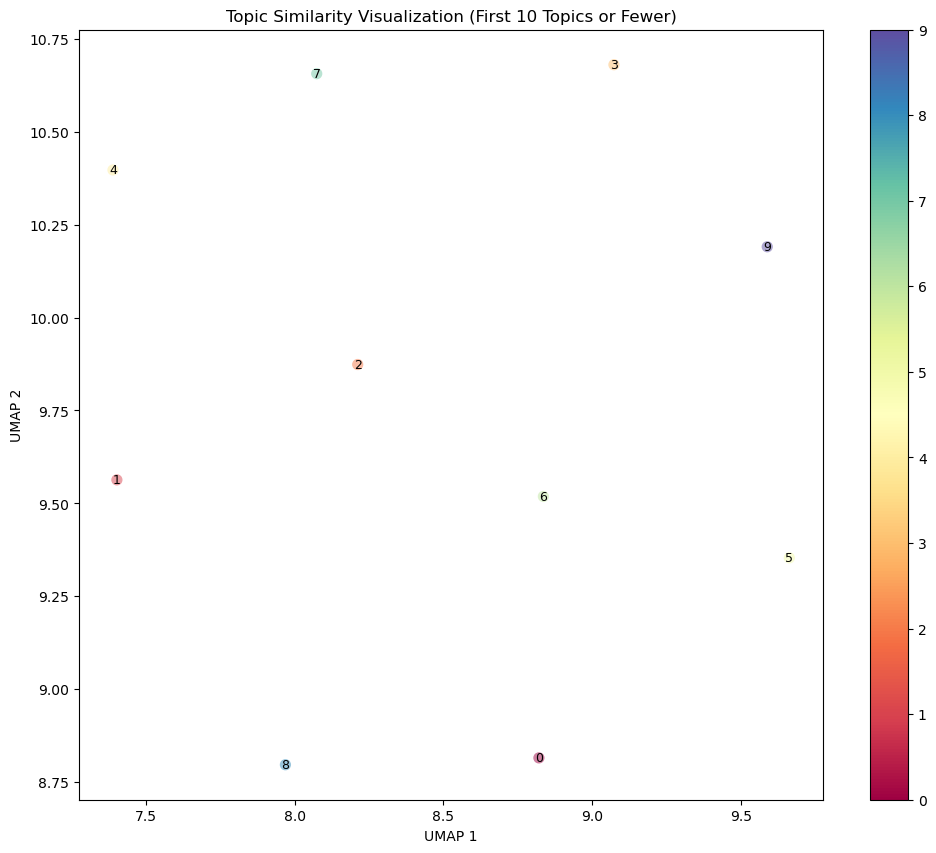

In [50]:
import matplotlib.pyplot as plt
from bertopic import BERTopic
import umap

# Assuming you already have the topic model trained
# topics, _ = topic_model.fit_transform(docs)

# 1. Access the topic embeddings directly
topic_embeddings = topic_model.topic_embeddings_

# Limit to the first 10 topics or fewer if there are less than 10
num_topics_to_visualize = min(10, len(topic_embeddings))
topic_embeddings_subset = topic_embeddings[:num_topics_to_visualize]

# 2. Reduce the dimensionality of the selected topic embeddings using UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_model.fit_transform(topic_embeddings_subset)

# 3. Plot the topics in 2D space to visualize their similarity
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=range(num_topics_to_visualize), cmap='Spectral', s=50)

# Add topic numbers as labels to each point
for i, (x, y) in enumerate(umap_embeddings):
    plt.text(x, y, str(i), fontsize=9, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Add colorbar and labels
plt.colorbar()
plt.title("Topic Similarity Visualization (First 10 Topics or Fewer)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [48]:
# Get the words associated with all topic
num_topics = len(topic_model.get_topics())
# number of topics
print(f"Number of topics: {num_topics}")
for i in range(num_topics):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

Number of topics: 23
Topic 0: [('deferred resignation', 0.0988743909569118), ('probationary period', 0.07254121776779972), ('special counsel', 0.06171813440744967), ('class action', 0.05166956284434125), ('effective date', 0.04601873706154718), ('termination letter', 0.03878006690173695), ('protection board', 0.035787414524161364), ('merit system protection', 0.035787414524161364), ('system protection board', 0.035787414524161364), ('deferred resignation program', 0.03422442003202716)]
Topic 1: [('opm gov', 0.1315310149528806), ('response opm', 0.09357517069699287), ('received opm', 0.0735934139950174), ('respond opm', 0.06785032898758571), ('what last', 0.06072464320975565), ('five bullet', 0.05076405087034257), ('chain command', 0.04454730499463567), ('classified information', 0.04146097001690842), ('told respond', 0.03960675334453416), ('what last week', 0.037852969888429164)]
Topic 2: [('gov worker', 0.04594154896551711), ('mental health', 0.04216259574957554), ('hold line', 0.0410